## Repeating Prediction

The idea here being: 
After 'week 1' in the testing timeline, train on all week one data available, from all other seasons. Then test on week 1 data from test dataset. 
After 'week 2' in the testing timeline, train on all week one and week two data available, then test on week 1 & week 2 data from test dataset.
(Continue in this format)

In [1]:
# Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os

In [2]:
# read in bachelorette demographic data
ette_demo = pd.read_csv("ette_cont_occ_group.csv")

In [3]:
ette_demo.columns

Index(['Name', 'Age', 'Occupation', 'Agreement_1', 'Hometown', 'ElimWeek',
       'Season'],
      dtype='object')

In [4]:
ette_demo['Season'].unique()

array([ 6,  9, 11, 12,  2,  5,  1, 10,  4,  8,  7], dtype=int64)

In [5]:
ette_demo['Season'].value_counts()

5     30
12    26
11    26
10    25
9     25
8     25
7     25
6     25
4     25
2     25
1     25
Name: Season, dtype: int64

In [6]:
ette_demo.head()

,Name,Age,Occupation,Agreement_1,Hometown,ElimWeek,Season
0,Derrick Schuster,27,Construction Engineer,Architecture and Engineering,"Manhattan Beach, California",1.0,6
1,Zak Waddell,31,Drilling Fluid Engineer,Architecture and Engineering,"Dallas, Texas",8.0,9
2,Clint Arlis,27,Architectural Engineer,Architecture and Engineering,"Batavia, Illinois",3.0,11
3,Nick Benvenutti,33,Electrical Engineer,Architecture and Engineering,"Carthage, Illinois",3.0,12
4,Will Haduch,26,Civil Engineer,Architecture and Engineering,"Jersey City, New Jersey",2.0,12


We have bachelorette demographic data on 11 seasons. We are missing season 3. All available seasons have 25 contestants, except 11 and 12 (with 26) and 5 (with 30).

Then we need to merge this demographic data with the elimination/date/rose data

In [7]:
elim = pd.read_csv("bachelorette_538.csv")

In [8]:
elim.columns
elim = elim.drop([0])

In [9]:
elim.head()

,SHOW,SEASON,CONTESTANT,ELIMINATION-1,ELIMINATION-2,ELIMINATION-3,ELIMINATION-4,ELIMINATION-5,ELIMINATION-6,ELIMINATION-7,...,DATES-1,DATES-2,DATES-3,DATES-4,DATES-5,DATES-6,DATES-7,DATES-8,DATES-9,DATES-10
1,Bachelorette,13,13_BRYAN_A,R1,NaN,NaN,R,R,NaN,R,...,NaN,NaN,D6,D13,D1,D7,D1,D1,D1,D1
2,Bachelorette,13,13_PETER_K,NaN,R,NaN,NaN,NaN,R,R,...,NaN,D1,D6,D13,D9,D7,D1,D1,D1,D1
3,Bachelorette,13,13_ERIC_B,NaN,NaN,R,NaN,NaN,R,R,...,NaN,D10,D8,D13,D9,D1,D3,D1,D1,NaN
4,Bachelorette,13,13_DEAN_U,NaN,R,NaN,R,NaN,NaN,R,...,NaN,D8,D8,D1,D9,D7,D1,D1,NaN,NaN
5,Bachelorette,13,13_ADAM_G,NaN,NaN,NaN,NaN,NaN,NaN,ED,...,NaN,D10,D8,D13,D9,D7,D3,NaN,NaN,NaN


In [10]:
elim_ette = elim[elim.SHOW == 'Bachelorette'].copy()

In [11]:
elim_ette = elim_ette[elim_ette.SEASON != 'SEASON'].copy()

In [12]:
elim_ette['SEASON'].unique()

array(['13', '12', '11', '10', '09', '08', '07', '06', '05', '04', '03',
       '02', '01'], dtype=object)

In [13]:
### need to figure out if we have the same contestant counts for each season
elim_ette['SEASON'].value_counts()
#elim_ette.columns

13    31
05    30
11    26
12    26
03    25
01    25
09    25
06    25
04    25
02    25
10    25
08    25
07    25
Name: SEASON, dtype: int64

We have bachelorette elimination data on 13 seasons. We have season 3 and 13, but will not be using them (lack of demographic data). All available seasons have 25 contestants, except 11 and 12 (with 26), 13 (with 31), and 5 (with 30).

## Merging Datasets together

In [14]:
# split elim CONTESTANT on "_"
elim_ette[['CON_SEASON', 'CON_FIRST', 'CON_INIT']] = elim_ette['CONTESTANT'].str.split('_',expand=True)
elim_ette.head()

# split bach CONTESTANT on " ",
ette_demo[['CON_FIRST', 'CON_LAST', 'CON_OTHER']] = ette_demo['Name'].str.split(' ', expand=True)
ette_demo.head()
#ette_demo.CON_OTHER.value_counts() # last names but also (state) or suffix
#ette_demo.CON_LAST.value_counts()

,Name,Age,Occupation,Agreement_1,Hometown,ElimWeek,Season,CON_FIRST,CON_LAST,CON_OTHER
0,Derrick Schuster,27,Construction Engineer,Architecture and Engineering,"Manhattan Beach, California",1.0,6,Derrick,Schuster,None
1,Zak Waddell,31,Drilling Fluid Engineer,Architecture and Engineering,"Dallas, Texas",8.0,9,Zak,Waddell,None
2,Clint Arlis,27,Architectural Engineer,Architecture and Engineering,"Batavia, Illinois",3.0,11,Clint,Arlis,None
3,Nick Benvenutti,33,Electrical Engineer,Architecture and Engineering,"Carthage, Illinois",3.0,12,Nick,Benvenutti,None
4,Will Haduch,26,Civil Engineer,Architecture and Engineering,"Jersey City, New Jersey",2.0,12,Will,Haduch,None


In [15]:

# make everything uppercase 
ette_demo.CON_FIRST = ette_demo.CON_FIRST.str.upper()
ette_demo.CON_LAST = ette_demo.CON_LAST.str.upper()
ette_demo.CON_OTHER = ette_demo.CON_OTHER.str.upper()

# keep only first initial of last name
ette_demo['CON_LAST2'] = ette_demo.CON_LAST.str[0]
ette_demo['CON_LAST3'] = ette_demo.CON_LAST.str[1]
ette_demo['CON_OTHER2'] = ette_demo.CON_OTHER.str[0]
# iterate through rows in order to keep correct letter
# logic will be: 
# if CON_LAST2 == '"' or if CON_LAST3 == '.' then keep CON_OTHER2
# if CON_OTHER2 == '(' or if CON_OTHER2.isnull then keep CON_LAST2, otherwise keep CON_OTHER2

ette_demo['INITIAL'] = np.where(ette_demo.CON_OTHER2.isnull or ette_demo.CON_OTHER2 == '(', ette_demo.CON_LAST2, ette_demo.CON_OTHER2)
ette_demo['INITIAL_FINAL'] = np.where((ette_demo.CON_LAST2 == '"') | (ette_demo.CON_LAST3 == '.'), ette_demo.CON_OTHER2, ette_demo.INITIAL)

ette_demo.INITIAL_FINAL.value_counts()
ette_demo.head()

,Name,Age,Occupation,Agreement_1,Hometown,ElimWeek,Season,CON_FIRST,CON_LAST,CON_OTHER,CON_LAST2,CON_LAST3,CON_OTHER2,INITIAL,INITIAL_FINAL
0,Derrick Schuster,27,Construction Engineer,Architecture and Engineering,"Manhattan Beach, California",1.0,6,DERRICK,SCHUSTER,None,S,C,None,S,S
1,Zak Waddell,31,Drilling Fluid Engineer,Architecture and Engineering,"Dallas, Texas",8.0,9,ZAK,WADDELL,None,W,A,None,W,W
2,Clint Arlis,27,Architectural Engineer,Architecture and Engineering,"Batavia, Illinois",3.0,11,CLINT,ARLIS,None,A,R,None,A,A
3,Nick Benvenutti,33,Electrical Engineer,Architecture and Engineering,"Carthage, Illinois",3.0,12,NICK,BENVENUTTI,None,B,E,None,B,B
4,Will Haduch,26,Civil Engineer,Architecture and Engineering,"Jersey City, New Jersey",2.0,12,WILL,HADUCH,None,H,A,None,H,H


In [16]:
# remove excess columns
ette_demo = ette_demo[['Name', 'Age', 'Occupation', 'Agreement_1', 'Hometown', 'ElimWeek', 'Season', 'CON_FIRST', 'INITIAL_FINAL']].copy()
ette_demo.head()

# make data types on merge columns the same
print(elim_ette.dtypes)
ette_demo.dtypes
elim_ette['SEASON'] = elim_ette['SEASON'].astype(str).astype(int)

SHOW              object
SEASON            object
CONTESTANT        object
ELIMINATION-1     object
ELIMINATION-2     object
ELIMINATION-3     object
ELIMINATION-4     object
ELIMINATION-5     object
ELIMINATION-6     object
ELIMINATION-7     object
ELIMINATION-8     object
ELIMINATION-9     object
ELIMINATION-10    object
DATES-1           object
DATES-2           object
DATES-3           object
DATES-4           object
DATES-5           object
DATES-6           object
DATES-7           object
DATES-8           object
DATES-9           object
DATES-10          object
CON_SEASON        object
CON_FIRST         object
CON_INIT          object
dtype: object


In [17]:
# merge/match on first name, last initial season number
all_data = elim_ette.merge(ette_demo, left_on = ['SEASON', 'CON_FIRST', 'CON_INIT'], right_on = ['Season', 'CON_FIRST', 'INITIAL_FINAL'])
all_data.head()

,SHOW,SEASON,CONTESTANT,ELIMINATION-1,ELIMINATION-2,ELIMINATION-3,ELIMINATION-4,ELIMINATION-5,ELIMINATION-6,ELIMINATION-7,...,CON_FIRST,CON_INIT,Name,Age,Occupation,Agreement_1,Hometown,ElimWeek,Season,INITIAL_FINAL
0,Bachelorette,12,12_JORDAN_R,R1,NaN,NaN,R,R,NaN,NaN,...,JORDAN,R,Jordan Rodgers,27,Former Pro Quarterback,Sports,"Chico, California",NaN,12,R
1,Bachelorette,12,12_ROBBY_H,NaN,NaN,NaN,NaN,R,NaN,R,...,ROBBY,H,Robby Hayes,27,Former Competitive Swimmer,Sports,"St. Augustine, Florida",10.0,12,H
2,Bachelorette,12,12_CHASE_M,NaN,NaN,R,NaN,NaN,R,NaN,...,CHASE,M,Chase McNary,27,Medical Sales Rep,Sales,"Castle Rock, Colorado",9.0,12,M
3,Bachelorette,12,12_LUKE_P,NaN,NaN,NaN,R,NaN,R,NaN,...,LUKE,P,Luke Pell,31,War Veteran,Military,"Burnet, Texas",8.0,12,P
4,Bachelorette,12,12_JAMES_T,NaN,R,R,NaN,NaN,NaN,E,...,JAMES,T,James Taylor,29,Singer-Songwriter,Entertainment and Media,"Katy, Texas",7.0,12,T


In [18]:
## check if numbers remain the same

print(all_data['SEASON'].unique())

all_data['SEASON'].value_counts()


[12 11 10  9  8  7  6  5  4  2  1]


5     30
7     27
12    26
11    26
10    25
9     25
8     25
6     25
4     25
2      7
1      4
Name: SEASON, dtype: int64

In [19]:
elim_ette['SEASON'].value_counts()

13    31
5     30
12    26
11    26
10    25
9     25
8     25
7     25
6     25
4     25
3     25
2     25
1     25
Name: SEASON, dtype: int64

Keep 11 unique seasons (plus missing).
Have lost people in merge.
Need to check on what is causing the loss.

(so, season 12, 4 should be okay, season 7 has one too many, all others are missing some.)

In [20]:
all_data[all_data.SEASON == 6].CON_INIT.value_counts()
# lost M from demo, lost N M X from elim

N    4
K    3
R    3
M    3
H    2
W    2
B    2
V    1
L    1
S    1
D    1
C    1
X    1
Name: CON_INIT, dtype: int64

In [21]:
#all_data[(all_data.Season == 9) & (all_data.INITIAL_FINAL == 'X')]

In [22]:
#ette_demo[(ette_demo.Season == 6)].INITIAL_FINAL.value_counts()
ette_demo[(ette_demo.Season == 6) & (ette_demo.INITIAL_FINAL == 'N')]
ette_demo[(ette_demo.Season == 6) & (ette_demo.CON_FIRST == 'DEREK')]

,Name,Age,Occupation,Agreement_1,Hometown,ElimWeek,Season,CON_FIRST,INITIAL_FINAL
221,Derek X,28,Sales Manager,Sales,"Warren, Michigan",1.0,6,DEREK,X


In [23]:
#elim_ette[(elim_ette.SEASON == 6)].CON_INIT.value_counts()
elim_ette[(elim_ette.SEASON == 6) & (elim_ette.CON_INIT == 'X')]

,SHOW,SEASON,CONTESTANT,ELIMINATION-1,ELIMINATION-2,ELIMINATION-3,ELIMINATION-4,ELIMINATION-5,ELIMINATION-6,ELIMINATION-7,...,DATES-4,DATES-5,DATES-6,DATES-7,DATES-8,DATES-9,DATES-10,CON_SEASON,CON_FIRST,CON_INIT
208,Bachelorette,6,06_DEREK_X,E,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06,DEREK,X


* Brian V in elimination, Bryan V in demo (Season 5) v
* J.P. in demo, JP in elimination (Season 7) v
* Two RYAN M (Season 7)
* J.J. L in demo, JJ L in elimination (Season 11) v
* Have a David X in elimiation data, not in demo (Season 11) v
* JJ O in elimiation, J.J. O in demo (Season 10) v
SEASON 8
* JEANPAUL in elim, JEAN-PAUL in demo v
* Randy Lee Woyak in demo should be RANDY W (not RANDY L) v
SEASON 9
* Juan Pablo Galavis in demo should be JUAN G, not JUAN P v
* MICAH X and MIKE X in elim should match up with MICAH None and MIKE None in demo (no last names listed)
SEASON 6
* ROBERTO M in demo is ROBERT M in elim v
* John N. (got changed to JOHN None) in demo needs to match with JOHN N in elim v
* DEREK None in demo should match with DEREK X in elim

### Rose and Date Visualization

In [34]:
all_data.columns

Index(['SHOW', 'SEASON', 'CONTESTANT', 'ELIMINATION-1', 'ELIMINATION-2',
       'ELIMINATION-3', 'ELIMINATION-4', 'ELIMINATION-5', 'ELIMINATION-6',
       'ELIMINATION-7', 'ELIMINATION-8', 'ELIMINATION-9', 'ELIMINATION-10',
       'DATES-1', 'DATES-2', 'DATES-3', 'DATES-4', 'DATES-5', 'DATES-6',
       'DATES-7', 'DATES-8', 'DATES-9', 'DATES-10', 'CON_SEASON', 'CON_FIRST',
       'CON_INIT', 'Name', 'Age', 'Occupation', 'Agreement_1', 'Hometown',
       'ElimWeek', 'Season', 'INITIAL_FINAL'],
      dtype='object')

In [44]:
roses = all_data[['SHOW', 'SEASON', 'CONTESTANT', 'ELIMINATION-1', 'ELIMINATION-2',
       'ELIMINATION-3', 'ELIMINATION-4', 'ELIMINATION-5', 'ELIMINATION-6',
       'ELIMINATION-7', 'ELIMINATION-8', 'ELIMINATION-9', 'ELIMINATION-10']].copy()
roses = pd.melt(roses, id_vars=['SHOW', 'SEASON', 'CONTESTANT'])
roses.head()

,SHOW,SEASON,CONTESTANT,variable,value
0,Bachelorette,12,12_JORDAN_R,ELIMINATION-1,R1
1,Bachelorette,12,12_ROBBY_H,ELIMINATION-1,NaN
2,Bachelorette,12,12_CHASE_M,ELIMINATION-1,NaN
3,Bachelorette,12,12_LUKE_P,ELIMINATION-1,NaN
4,Bachelorette,12,12_JAMES_T,ELIMINATION-1,NaN


In [46]:
# only roses
roses.value.unique()
season_roses = roses[((roses.value == 'R1') | (roses.value == 'R'))].copy()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002367D6122B0>]],
      dtype=object)

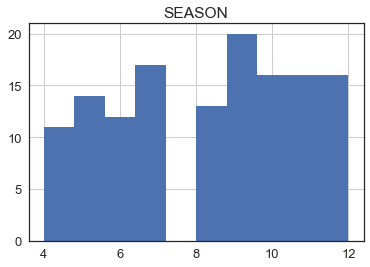

In [48]:
season_roses.hist()

### Actual Iterative System Using this Combined Data

In [24]:
all_data.columns

Index(['SHOW', 'SEASON', 'CONTESTANT', 'ELIMINATION-1', 'ELIMINATION-2',
       'ELIMINATION-3', 'ELIMINATION-4', 'ELIMINATION-5', 'ELIMINATION-6',
       'ELIMINATION-7', 'ELIMINATION-8', 'ELIMINATION-9', 'ELIMINATION-10',
       'DATES-1', 'DATES-2', 'DATES-3', 'DATES-4', 'DATES-5', 'DATES-6',
       'DATES-7', 'DATES-8', 'DATES-9', 'DATES-10', 'CON_SEASON', 'CON_FIRST',
       'CON_INIT', 'Name', 'Age', 'Occupation', 'Agreement_1', 'Hometown',
       'ElimWeek', 'Season', 'INITIAL_FINAL'],
      dtype='object')

In [25]:
bachelorette = all_data[['SEASON', 'Name', 'ELIMINATION-1', 'ELIMINATION-2',
       'ELIMINATION-3', 'ELIMINATION-4', 'ELIMINATION-5', 'ELIMINATION-6',
       'ELIMINATION-7', 'ELIMINATION-8', 'ELIMINATION-9', 'ELIMINATION-10',
       'DATES-1', 'DATES-2', 'DATES-3', 'DATES-4', 'DATES-5', 'DATES-6',
       'DATES-7', 'DATES-8', 'DATES-9', 'DATES-10', 'Age', 'Occupation', 'Agreement_1', 'Hometown']].copy()

so after 'week 1' we would use the following variables to predict: 
* DATES-1, Age, Occupation/Agreement_1, Hometown
after 'week 2' we would use: 
* DATES-1, Age, Occupation/Agreement_1, Hometown + DATES-2

ELIMINATION-1, etc. would be used to remove people from our data set after each round

for experiment sake, each time, we will train on seasons 11 10  9  8  7  6  5  4  2  1 
and test on season 12

### Choose test and train sets

### Enter the System

In [91]:
test_bach = bachelorette[bachelorette.SEASON == 12]
train_bach = bachelorette[bachelorette.SEASON != 12]

week = 1
vars_to_use = ['Age', 'Occupation', 'Agreement_1', 'Hometown'] ### will need more variables including roses

while week <= 8: # ten weeks of data available
    
    new_var = 'DATES-' + str(week)
    vars_to_use.append(new_var)
    
    # train on correct variables based on week
    ### need 'WINNER' binary as right/wrong
    this_train = train_bach[vars_to_use].copy()
    
    # test on correct variables based on week
    this_test = test_bach[vars_to_use].copy()
    
    # remove contestants based on ELIMINATION
    e_week_name = 'ELIMINATION-' + str(week)
    
    # keep them if their elimination value is null or is R (rose)
    test_bach = test_bach[(test_bach[e_week_name].isnull()) | (test_bach[e_week_name] == 'R')]
    train_bach = train_bach[(train_bach[e_week_name].isnull()) | (train_bach[e_week_name] == 'R')]
    
    # increment time
    week = week + 1
    
this_train

,Age,Occupation,Agreement_1,Hometown,DATES-1,DATES-2,DATES-3,DATES-4,DATES-5,DATES-6,DATES-7,DATES-8
27,34,Software Sales Executive,Sales,"Waukesha, Wisconsin",NaN,NaN,NaN,NaN,D9,D1,D3,D1
28,26,Software Salesman,Sales,"Warsaw, Indiana",NaN,D8,D6,D5,D1,D5,D1,D1
50,29,Former Professional Baseball Player,Sports,"Athens, Georgia",NaN,D14,D12,NaN,D1,D6,D1,D1
52,32,Farmer,Farming/Fishing/Forestry,"Lamont, Iowa",NaN,D1,NaN,NaN,D9,D6,D4,D1
53,25,Sports Medicine Manager,Manager,"Medicine Hat, Alberta",NaN,D14,D12,D1,D9,D6,D1,D1
74,27,Mortgage Broker,Real Estate/Realtor,"McMinnville, Oregon",NaN,NaN,D10,D10,D1,D6,D1,D1
76,28,Sales & Marketing,Sales,"Blackfoot, Idaho",NaN,D1,D10,D10,D7,D6,D1,D1
96,27,Entrepreneur,Entrepreneur,"St. George, Utah",NaN,D13,D12,D8,D1,D6,D1,D1
97,30,Race Car Driver,Sports,"Scottsdale, Arizona",NaN,NaN,D1,D8,D8,D6,D1,D1
98,28,Insurance Agent,Other,"Irving, Texas",NaN,NaN,D12,D8,D1,D6,D3,D1
